In [78]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

In [6]:
DATASET_NAME = "sherbrooke"

In [7]:
# Create normal trajectories dataset
normal_data_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_data.csv"
normal_data = np.genfromtxt(normal_data_file, delimiter=',')
# Remove the first column, which is the object_id
normal_data = normal_data[:, 1:]
print(f"Normal data shape: {normal_data.shape}")

# Create the generated abnormal dataset
abnormal_data_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_abnormal.csv"
abnormal_data = np.genfromtxt(abnormal_data_file, delimiter=',')
# Remove the first column, which is the object_id
abnormal_data = abnormal_data[:, 1:]
print(f"Abnormal data shape: {abnormal_data.shape}")

# Create the real abnormal datasets
real_abnormal_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal.csv"
real_abnormal_file_2 = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal_2.csv"
real_abnormal_data = np.genfromtxt(real_abnormal_file, delimiter=',')
real_abnormal_data_2 = np.genfromtxt(real_abnormal_file_2, delimiter=',')
# Remove the first column, which is the object_id
real_abnormal_data = real_abnormal_data[:, 1:]
real_abnormal_data_2 = real_abnormal_data_2[:, 1:]
print(f"Real abnormal data shape: {real_abnormal_data.shape}")

Normal data shape: (20606, 125)
Abnormal data shape: (186, 125)
Real abnormal data shape: (406, 125)


In [73]:
# Define the DAE
class DAE(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layers=(16,),
                 hidden_activation=nn.ReLU,
                 output_activation=nn.Sigmoid
                 ):
        super(DAE, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Add the encoding layers
        self.encoded = self.create_layers(hidden_layers, input_size)

        # Add the decoding layers with the output activation function
        self.decoded = self.create_layers(hidden_layers[-2::-1], hidden_layers[-1])
        self.decoded.append(nn.Linear(hidden_layers[0], input_size))
        self.decoded.append(self.output_activation())

    def create_layers(self, design, input_size):
        layers = []
        for i, layer in enumerate(design):
            in_features = design[i-1] if i > 0 else input_size
            out_features = layer
            layers.append(nn.Linear(in_features, out_features))
            layers.append(self.hidden_activation())

        return nn.Sequential(*layers)

    def forward(self, input):
        encoded = self.encoded(input)
        # print(self.decoded)
        decoded = self.decoded(encoded)
        return decoded

In [81]:
BATCH_SIZE = 128
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(normal_data)
train_data_scaled = torch.from_numpy(train_data_scaled).to(DEVICE, dtype=torch.float32)

# Create the KFold object for cross validation
folds = 10
splits = KFold(n_splits=folds, shuffle=True, random_state=42)

# Split into training and validation
# train_data_scaled, validation_data_scaled = train_test_split(train_data_scaled, test_size=0.2)
# train_data_scaled = torch.from_numpy(train_data_scaled)
# validation_data_scaled = torch.from_numpy(validation_data_scaled)

# train_dataloader = torch.utils.data.DataLoader(train_data_scaled, batch_size=BATCH_SIZE, shuffle=True)
# validation_dataloader = torch.utils.data.DataLoader(validation_data_scaled, batch_size=BATCH_SIZE, shuffle=True)

In [72]:
hidden_layers = (128,64,32,16,8)
print(hidden_layers[-2::-1])
# Define the model
model = DAE(input_size=train_data_scaled.shape[1], hidden_layers=hidden_layers).to(DEVICE)

(16, 32, 64, 128)
Sequential()


In [82]:
print(DEVICE)

cpu


In [75]:
print("Training the deep autoencoder")
# Define hyperparameters
EPOCHS = 100
HIDDEN_LAYERS = (16,)
criterion = nn.MSELoss()
hidden_layers = (128,64,32,16,8)

# Define the model
model = DAE(input_size=train_data_scaled.shape[1], hidden_layers=hidden_layers).to(DEVICE)
optimizer = torch.optim.RMSprop(model.parameters())


history = {
    'train': [],
    'val': []
}

for fold, (train_idx, val_idx) in enumerate(splits.split(train_data_scaled)):
    print(f"Fold {fold+1}")
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=train_sampler)
    validation_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=validation_sampler)

    # Train the model on the scaled data
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch}")
        total_train_loss = 0
        total_validation_loss = 0
        for i, trajectories in enumerate(train_dataloader):
            trajectories = trajectories.to(DEVICE, dtype=torch.float32)
            # print(type(trajectories[0]))

            # Forward pass
            model.zero_grad()
            output = model(trajectories)
            loss = criterion(output, trajectories)
            total_train_loss += loss / len(train_dataloader)

            # Backward pass
            loss.backward()
            optimizer.step()
        print(f"Train loss: {total_train_loss}")
        history['train'].append(total_train_loss)

        # Evaluate model at this epoch
        model.eval()
        with torch.no_grad():
            for i, trajectories in enumerate(validation_dataloader):
                trajectories = trajectories.to(DEVICE, dtype=torch.float32)
                output = model(trajectories)
                loss = criterion(output, trajectories)

                total_validation_loss += loss / len(validation_dataloader)
        print(f"Validation loss: {total_validation_loss}")
        history['val'].append(total_validation_loss)
        model.train()

Training the deep autoencoder
Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=128, bias=True)
  (7): ReLU()
)
Fold 1
Epoch 0
Train loss: 0.02086138352751732
Validation loss: 0.011906358413398266
Epoch 1
Train loss: 0.01186604704707861
Validation loss: 0.012391566298902035
Fold 2
Epoch 0
Train loss: 0.01181076467037201
Validation loss: 0.009202748537063599
Epoch 1
Train loss: 0.010034952312707901
Validation loss: 0.008614448830485344
Fold 3
Epoch 0
Train loss: 0.009441942907869816
Validation loss: 0.017600681632757187
Epoch 1
Train loss: 0.008953096345067024
Validation loss: 0.008304408751428127
Fold 4
Epoch 0
Train loss: 0.008884078823029995
Validation loss: 0.007960272952914238
Epoch 1
Train loss: 0.0087712612003088
Validation loss: 0.014053992927074432
Fold 5
Epoch 

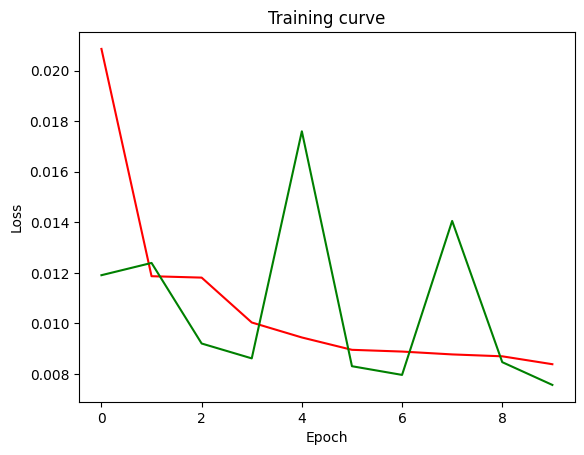

In [80]:
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train'])),history['train'],'r')
    plt.plot(range(len(history['val'])),history['val'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [41]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predicted_train_data = model(train_data_scaled)
    assert predicted_train_data.shape == train_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data_scaled[i], predicted_train_data[i]) for i in range(train_data_scaled.shape[0])]
    train_score = np.mean(mse_per_sample)
    print(f"Train score: {train_score}")

    predicted_validation_data = model(validation_data_scaled)

0.0021303222
